In [22]:
import tensorflow as tf
from tensorflow import keras
import cv2

In [23]:
DATASET_DIR= "./data"
EPOCHS = 15
BATCH_SIZE = 32

Import Dataset

In [30]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  # validation_split=0.2
)

train_ds = train_datagen.flow_from_directory(
  F"{DATASET_DIR}/train",
  batch_size=BATCH_SIZE,
  target_size=(128, 128),
  # class_mode='categorical',
  # subset='training'
)

Found 911 images belonging to 3 classes.


In [31]:
val_datagen = ImageDataGenerator()

val_ds = val_datagen.flow_from_directory(
  F"{DATASET_DIR}/valid",
  batch_size=BATCH_SIZE,
  target_size=(128, 128),
  # class_mode='categorical',
  # subset='validation'
)

Found 219 images belonging to 3 classes.


In [33]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Build The CNN

In [72]:
model = keras.models.Sequential([
    keras.layers.Rescaling(1./255, input_shape=(None, None, 3)),
    keras.layers.Conv2D(32, 3, activation="relu", padding="same"),

    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, activation="relu", padding="same"),

    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),

    # keras.layers.Dropout(0.25),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),

    # keras.layers.Dropout(0.25),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation="relu"),

    keras.layers.Dense(3, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, None, None, 3)     0         
                                                                 
 conv2d_72 (Conv2D)          (None, None, None, 32)    896       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, None, None, 32)   0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, None, None, 64)    18496     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, None, None, 64)   0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, None, None, 128) 

Training

In [73]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    # steps_per_epoch=train_ds.samples/train_ds.batch_size,
    batch_size=BATCH_SIZE,
    # validation_steps=validation_ds.samples/validation_ds.batch_size
)

Epoch 1/15
29/29 [==============================] - 14s 479ms/step - loss: 1.0789 - categorical_accuracy: 0.3809 - val_loss: 0.9761 - val_categorical_accuracy: 0.5708
Epoch 2/15
29/29 [==============================] - 13s 463ms/step - loss: 0.9809 - categorical_accuracy: 0.4687 - val_loss: 0.8829 - val_categorical_accuracy: 0.6256
Epoch 3/15
29/29 [==============================] - 13s 455ms/step - loss: 0.8460 - categorical_accuracy: 0.6224 - val_loss: 0.7769 - val_categorical_accuracy: 0.6895
Epoch 4/15
29/29 [==============================] - 14s 477ms/step - loss: 0.8354 - categorical_accuracy: 0.5939 - val_loss: 0.9519 - val_categorical_accuracy: 0.5388
Epoch 5/15
29/29 [==============================] - 13s 462ms/step - loss: 0.8409 - categorical_accuracy: 0.6180 - val_loss: 0.7260 - val_categorical_accuracy: 0.6849
Epoch 6/15
29/29 [==============================] - 13s 457ms/step - loss: 0.7492 - categorical_accuracy: 0.6685 - val_loss: 0.6185 - val_categorical_accuracy: 0.716

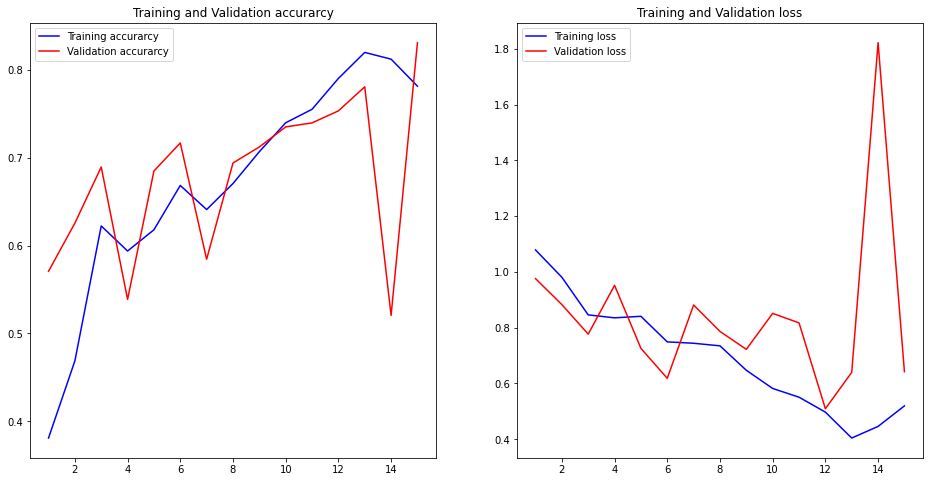

In [74]:
from matplotlib import pyplot as plt

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "b", label="Training accurarcy")
plt.plot(epochs, val_acc, "r", label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

# Train and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

Prediction

In [75]:
print(train_ds.class_indices)

{'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}


In [76]:
import numpy as np

img = keras.utils.load_img(
  f"{DATASET_DIR}/test/Leaf smut/smut-_0_154.jpg",
  # target_size=(128, 128)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
# class_names = train_ds.class_names
print(
    100*score
)

1/1 [==============================] - 0s 302ms/step
tf.Tensor([24.524698 28.99977  46.47554 ], shape=(3,), dtype=float32)
